# Sudoku Solver


In [1]:
import numpy as np
import pandas as pd
import cv2

In [41]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from google.colab.patches import cv2_imshow as imshow

## Loading Dataset

In [42]:
!git clone https://github.com/wichtounet/sudoku_dataset/


fatal: destination path 'sudoku_dataset' already exists and is not an empty directory.


In [43]:
!ls sudoku_dataset/images | tail

image96.dat
image96.jpg
image97.dat
image97.jpg
image98.dat
image98.jpg
image99.dat
image99.jpg
image9.dat
image9.jpg


## Get data from sudoku images
---



In [5]:
df = pd.read_csv('/content/sudoku_dataset/outlines_sorted.csv')
df['filepath']=df['filepath'].apply(lambda path: '/content/sudoku_dataset' + path[1:-4])

In [6]:
df.head()

,filepath,p1_x,p1_y,p2_x,p2_y,p3_x,p3_y,p4_x,p4_y
0,/content/sudoku_dataset/images/image32,112,35,583,35,600,435,105,444
1,/content/sudoku_dataset/images/image1082,101,270,885,272,872,1060,105,1053
2,/content/sudoku_dataset/images/image125,13,11,409,0,423,415,10,427
3,/content/sudoku_dataset/images/image50,41,10,552,4,568,443,30,446
4,/content/sudoku_dataset/images/image188,14,10,534,9,538,447,20,457


In [44]:
def process_image(path: str):
  #Load image
  img = cv2.imread(path)

  try:
    if img is None:
      raise Exception

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY, 11, 3)
    img = 255 - img
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    contours, h = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)
    img = img[y:y + h, x:x + w]
    img = cv2.resize(img, (288, 288))
    return img
  except Exception:
    return None


In [45]:
def ground_truth(path: str):
  with(open(path, 'r')) as fin:
    lines = fin.readlines()
    truth = []
    for line in lines[2:]:
      for value in line.split():
        truth.append(int(value))

    return np.array(truth)
  

In [46]:
X = []
y = []

for i in tqdm(range(df.shape[0])):
  path = str(df.iloc[i, 0])
  X.append(process_image(path + '.jpg'))
  y.append(ground_truth(path + '.dat'))


X = np.array(X) / 255.
y = np.array(y)

100%|██████████| 202/202 [00:04<00:00, 44.58it/s]


### Splitting into train and test data

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [48]:
print('Train Shape: ', X_train.shape)
print('Test  Shape: ', X_test.shape)

Train Shape:  (161, 288, 288)
Test  Shape:  (41, 288, 288)


In [49]:
print('Train Shape: ', y_train.shape)
print('Test  Shape: ', y_test.shape)

Train Shape:  (161, 81)
Test  Shape:  (41, 81)


### Test section [IGNORE]

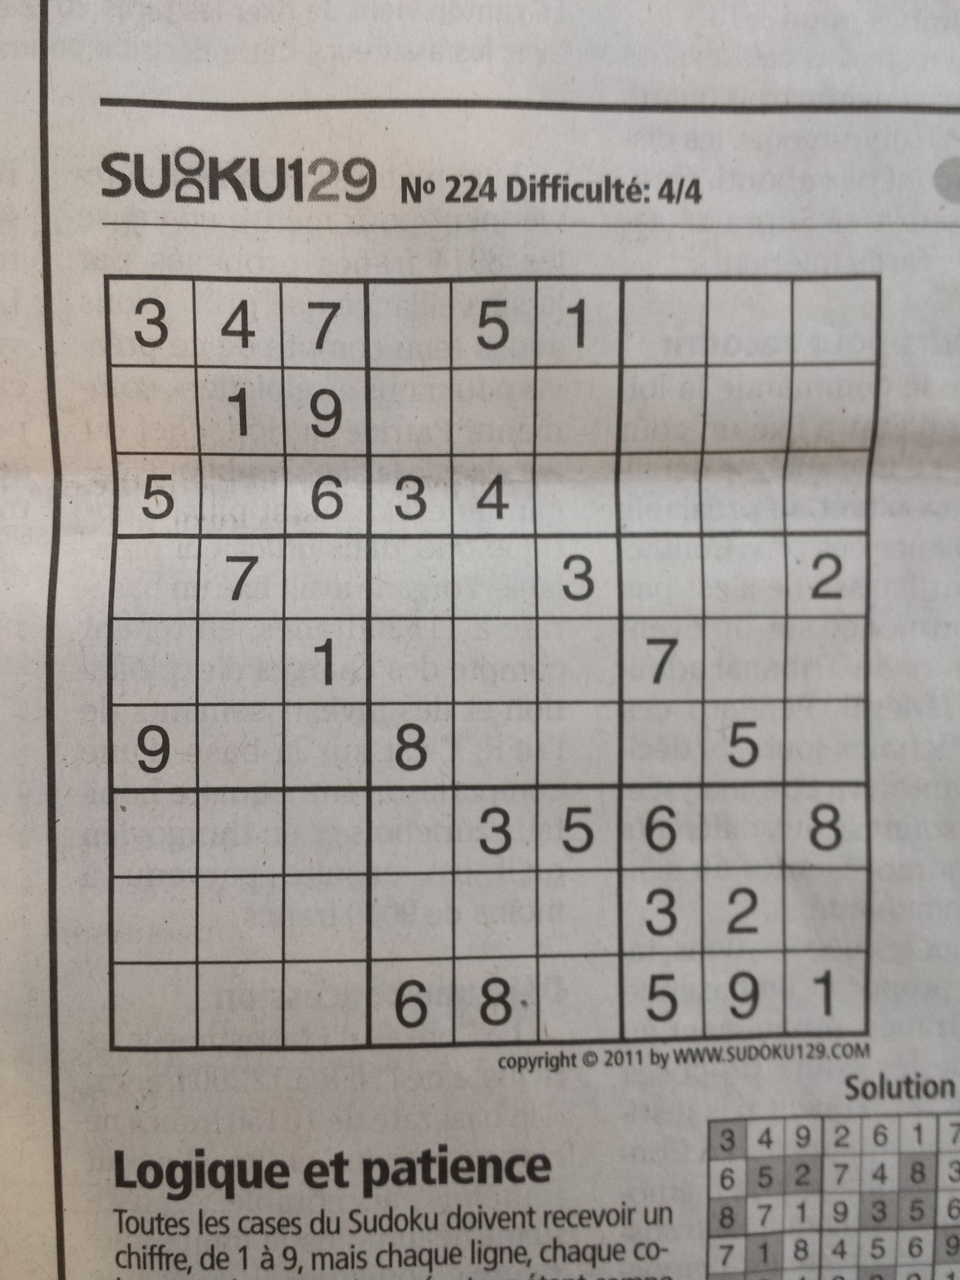

In [13]:
original = cv2.imread('/content/sudoku_dataset/images/image1082.jpg')
imshow(original)

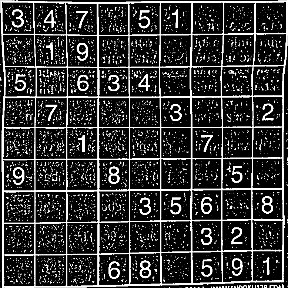

In [14]:
processed = process_image('/content/sudoku_dataset/images/image1082.jpg')
if processed is not None:
  imshow(processed)
else:
  print("Error")

In [15]:
ground_truth('/content/sudoku_dataset/images/image1082.dat')

array([3, 4, 7, 0, 5, 1, 0, 0, 0, 0, 1, 9, 0, 0, 0, 0, 0, 0, 5, 0, 6, 3,
       4, 0, 0, 0, 0, 0, 7, 0, 0, 0, 3, 0, 0, 2, 0, 0, 1, 0, 0, 0, 7, 0,
       0, 9, 0, 0, 8, 0, 0, 0, 5, 0, 0, 0, 0, 0, 3, 5, 6, 0, 8, 0, 0, 0,
       0, 0, 0, 3, 2, 0, 0, 0, 0, 6, 8, 0, 5, 9, 1])

## Training Character Recognition

In [50]:
def get_cells(sudoku, size=288):
  cells = []
  cell_shape = size // 9
  for i in range(9):
    i = cell_shape * i
    for j in range(9):
      j = j * cell_shape
      cell = sudoku[i: i+cell_shape, j: j+cell_shape]
      cells.append(cell)

  return np.array(cells)


In [51]:
digit_train_img = []
digit_train_truth = []
for i, sudoku in enumerate(X_train):
  digit_train_img.extend(get_cells(sudoku, size=288))
  digit_train_truth.extend(y_train[i])

digit_train_truth = np.array(digit_train_truth)
digit_train_img = np.array(digit_train_img)


In [52]:
digit_train_img = np.reshape(digit_train_img, (digit_train_img.shape[0], 32, 32, 1))

In [53]:
from tensorflow.keras.utils import to_categorical

In [54]:
digit_train_truth = to_categorical(digit_train_truth, 10)

In [55]:
d_train, d_test, v_train, v_test = train_test_split(digit_train_img, digit_train_truth, test_size=0.2)

In [22]:
print('Train digits: ',d_train.shape)
print('Test  digits: ',d_test.shape)

Train digits:  (10432, 32, 32, 1)
Test  digits:  (2609, 32, 32, 1)


In [56]:
print('Train values: ',v_train.shape)
print('Test  valuess: ',v_test.shape)

Train values:  (10432, 10)
Test  valuess:  (2609, 10)


# Training Digit recognizer

In [57]:
import matplotlib.pyplot as plt


[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


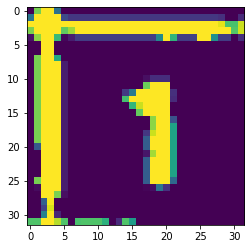

In [82]:
var=234
plt.imshow(d_train[var].reshape(32, 32))
print(str(v_train[var]))

In [83]:
val=model.predict(d_train[var].reshape(1, 32, 32, 1))
print(np.argmax(val, axis=1))

[1]


In [59]:
import tensorflow as tf
import tensorflow.keras as keras

In [60]:
from keras import Sequential
from keras.layers import *
from keras.regularizers import *
from keras.callbacks import *
from keras.optimizers import Adam

In [61]:
model = Sequential(name='Digit Classifier')
model.add(Conv2D(32, (3, 3),input_shape=(32, 32,1), padding='same', activation='relu', kernel_regularizer=l2()))
model.add(Conv2D(32, (3, 3),input_shape=(32, 32,1), padding='same', activation='relu', kernel_regularizer=l2()))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(rate=0.2))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2()))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2()))
model.add(Dropout(rate=0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2()))
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3))

Model: "Digit Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)     

In [62]:
LR_reduce=ReduceLROnPlateau(monitor='val_accuracy',
                            factor=.67,
                            patience=10,
                            min_lr=.1e-5,
                            verbose=1)

ES_monitor=EarlyStopping(monitor='val_loss',
                          patience=15)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, _, logs={}):
        if logs.get('accuracy') > 0.995:
            self.model.stop_training=True

In [63]:
history = model.fit(d_train, v_train, batch_size=256, validation_data=(d_test, v_test), epochs=300, callbacks=[LR_reduce, ES_monitor, myCallback()])

Train on 10432 samples, validate on 2609 samples
Epoch 1/300
10432/10432 [==============================] - 1s 118us/step - loss: 8.2932 - accuracy: 0.6233 - val_loss: 5.7944 - val_accuracy: 0.6550
Epoch 2/300
10432/10432 [==============================] - 1s 68us/step - loss: 3.4870 - accuracy: 0.6872 - val_loss: 3.4248 - val_accuracy: 0.6861
Epoch 3/300
10432/10432 [==============================] - 1s 68us/step - loss: 2.0253 - accuracy: 0.7118 - val_loss: 2.5794 - val_accuracy: 0.7175
Epoch 4/300
10432/10432 [==============================] - 1s 68us/step - loss: 1.4600 - accuracy: 0.7367 - val_loss: 2.1064 - val_accuracy: 0.7363
Epoch 5/300
10432/10432 [==============================] - 1s 67us/step - loss: 1.1304 - accuracy: 0.7895 - val_loss: 1.8927 - val_accuracy: 0.7693
Epoch 6/300
10432/10432 [==============================] - 1s 69us/step - loss: 0.9372 - accuracy: 0.8431 - val_loss: 1.5556 - val_accuracy: 0.8072
Epoch 7/300
10432/10432 [==============================] - 1s 

## Graphs

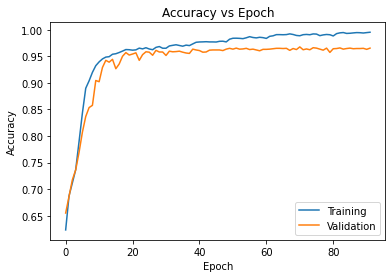

In [64]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy vs Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

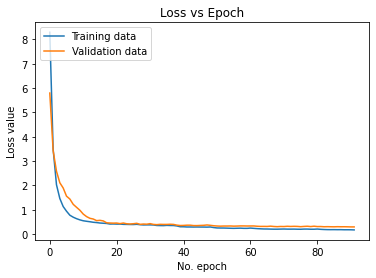

In [65]:
plt.plot(history.history['loss'], label='Training data')
plt.plot(history.history['val_loss'], label='Validation data')
plt.title('Loss')
plt.ylabel('Loss value')
plt.title('Loss vs Epoch')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#### Saving Model

In [66]:
model.save('model.h5')

## Analysing Classifier

In [67]:
v_pred = model.predict(d_test)
v_pred = np.argmax(v_pred, axis=1)
v_test = np.argmax(v_test, axis=1)

In [68]:
from sklearn.metrics import classification_report

In [69]:
print(classification_report(
  y_true=v_test,
  y_pred=v_pred
))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1663
           1       0.92      0.88      0.90        94
           2       0.97      0.93      0.95       104
           3       0.98      0.91      0.94       116
           4       0.92      0.92      0.92        86
           5       0.91      0.89      0.90        96
           6       0.94      0.91      0.93        93
           7       0.96      0.95      0.96       108
           8       0.94      0.95      0.94       129
           9       0.96      0.94      0.95       120

    accuracy                           0.97      2609
   macro avg       0.95      0.93      0.94      2609
weighted avg       0.97      0.97      0.97      2609



# Analysing model on Unseen Sudokus

In [37]:
def compare_outputs(pred, truth):
  errors = 0
  for i in range(len(pred)):
    if pred[i] != truth[i]:
      errors += 1
    break

  if errors:
    return 0
  return 1

In [70]:
accurate = 0
total = 0

for i in range(len(X_test)):
  sudoku = X_test[i]
  cells = get_cells(sudoku, size=288)
  cells = np.reshape(cells, (cells.shape[0], 32, 32, 1))
  v_true = y_test[i]
  v_pred = model.predict(cells)
  v_pred = np.argmax(v_pred, axis=1)
  accurate += compare_outputs(pred=v_pred, truth=v_true)
  total +=1

print('Accuracy: ', (accurate/total))

Accuracy:  0.926829268292683


In [71]:
print(total)

41


## Driver Function

In [87]:
def get_sudoku(path: str):
  try:
    img = cv2.imread(path)
    imshow(img)
    print()
    print()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.adaptiveThreshold(img.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                    cv2.THRESH_BINARY, 11, 3)
    img = 255 - img
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

    contours, h = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_contour)
    img = img[y:y + h, x:x + w]
    imshow(img)
    print()
    print()
    sudoku = cv2.resize(img, (288, 288))

    cells = get_cells(sudoku, 288)
    cells = np.reshape(cells, (cells.shape[0], 32, 32, 1))
    v_pred = model.predict(cells)
    v_pred = np.argmax(v_pred, axis=1)
    print(v_pred)
    sudoku_ext = np.reshape(v_pred, (9, 9))
    print(sudoku_ext)
  except Exception:
    print("Invalid Path")


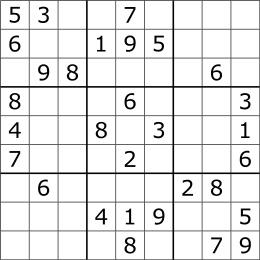

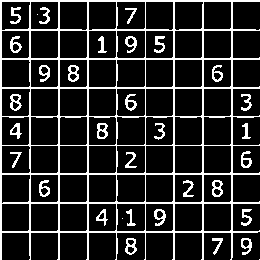



[8 8 5 5 6 5 6 6 6 6 5 5 8 8 8 6 6 6 5 8 8 5 5 5 6 8 5 8 5 5 5 6 5 6 6 8 8
 5 5 8 5 8 5 6 8 6 0 0 0 8 5 0 0 8 5 6 5 5 5 5 8 8 5 5 5 5 8 8 8 6 6 8 6 5
 5 5 8 5 6 6 8]
[[8 8 5 5 6 5 6 6 6]
 [6 5 5 8 8 8 6 6 6]
 [5 8 8 5 5 5 6 8 5]
 [8 5 5 5 6 5 6 6 8]
 [8 5 5 8 5 8 5 6 8]
 [6 0 0 0 8 5 0 0 8]
 [5 6 5 5 5 5 8 8 5]
 [5 5 5 8 8 8 6 6 8]
 [6 5 5 5 8 5 6 6 8]]


In [88]:
get_sudoku('/content/test3.jpeg')